# Загрузка данных и библиотек

In [1]:
pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=eca5c7860e1e9edab1429c2312a964f356136bbd53521a6f6ef70e0e78229ac7
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.5 MB/s eta 0:00:00


In [3]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tempfile

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

from tensorflow import keras, feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
# Последовательная модель НС
from tensorflow.keras.models import Sequential  
# Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
# Утилиты для to_categorical()
from tensorflow.keras import utils   
# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam, Adadelta   
# Связь с google-диском
#from google.colab import files   
# Предварительная обработка данных
from sklearn import preprocessing                 

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

file_path = 'chd_addmit_300.xlsx'
# удаляем даты
dataframe = pd.read_excel(file_path).drop(['birth','admittion',	'discharge', 'Дата опер.'], axis=1)

# этот признак работает криво. исправлю здесь
#dataframe['sex'] = dataframe['sex'].apply(lambda x: 1 if x=='f' else 0)
#dataframe = dataframe.drop('sex', axis=1)

In [5]:
# англофикация названий признаков. Необходимо для сохранения модели
count = 0
data = dataframe.copy()
for col in data.drop('target', axis=1).columns:
    data = data.rename(columns={col: f"col_{count}"})
    count += 1
    
dataframe = data

# Входной пайплайн df_to_dataset. Подготовка датасета. Предобработка. Сплит на выборки

Первый шаг заключается в преобразовании датафреймов Pandas в наборы данных TensorFlow:

In [6]:
# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')

# Разделяем на выборки

# вариант разделения по туториалам. пусть будет пока
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

X_train, X_test, y_train, y_test = train_test_split(dataframe, dataframe['target'], 
                                                      test_size=0.3, 
                                                      random_state=5,
                                                      stratify=dataframe['target'])

# RandomOverSampler. Балансируем классы!
X_train, y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)
y_train = y_train.reset_index(drop=True)

# Преобразуем датафрейм Pandas в наборы данных TensorFlow
batch_size = 256
train_ds = df_to_dataset(X_train, batch_size=batch_size)
test_ds = df_to_dataset(X_test, shuffle=False, batch_size=batch_size)

<ipython-input-6-1b0bd38eb9d9>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-6-1b0bd38eb9d9>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Здесь стоит обратить внимание на то, что наборы данных TensorFlow и результаты дальнейших преобразований данных не хранятся в памяти так же, как хранятся датафреймы Pandas. Они, по сути, представляют собой конвейер. Через него, пакет за пакетом, походят данные, что позволяет модели эффективно обучаться на наборах данных, которые слишком велики для размещения их в памяти. Именно поэтому мы преобразуем в наборы данных словари датафреймов, а не реальные данные. Обратите внимание на то, что мы, кроме прочего, задаём сейчас, а не во время обучения модели, размер пакета данных, поступая не так, как обычно поступают при использовании API Keras.

## Нормализация входных/выходных данных

In [7]:
# предобработка слоя с числовыми призанками
def get_normalization_layer(name, dataset):
  # Создаем слой нормализации для объекта.
  normalizer = layers.Normalization(axis=None)
  # Подготовка набора данных, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Обучить статистику данных.
  normalizer.adapt(feature_ds)
  return normalizer

# предобработка слоя с категориальными призанками
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Создайтся слой, который превращает строки в целые индексы.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # В противном случае создайтся слой, который превращает целые значения в целые индексы.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  # Подготовка `tf.data.Dataset`, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Изучить набор возможных значений и присвоить им фиксированный целочисленный индекс.
  index.adapt(feature_ds)
  # Кодировать целочисленные индексы.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  # Применить многократное горячее кодирование к индексам. Лямбда-функция захватывает слои,
  # чтобы вы могли использовать их или позже включить в функциональную модель Keras.
  return lambda feature: encoder(index(feature))

all_inputs = [] # inputs
encoded_features = [] # output

# Numerical features.
for header in dataframe.columns.tolist():
  if dataframe[header].dtypes in ['float64', 'int64']:
    # inputs
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # output
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    # append
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# Сategorical features.
categorical_cols = dataframe.loc[:,dataframe.dtypes == 'object'].columns.tolist()
for header in categorical_cols:
    # inputs
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # output
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    # append
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


In [8]:
# inputs
display(all_inputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'col_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'col_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'col_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'col_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'target')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_0')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_5')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_6')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_7')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_8')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_9')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_10')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_11')>,
 <KerasTensor: shape=(None, 1) dtype=string

In [9]:
# output
display(encoded_features)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by

# Обучение. Подбор параметров

Здесь главное правильно указать первый слой (наши признаки) и последний (количество классов в таргете). Но тк их всего два то можно указать единицу, что я и сделал. Все остальное завист от уровня знаний и предпочтений. Нужно экспериментировать

```python
%%time

# модуль обучения
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


#'relu', 'linear', 'sigmoid', 'softmax'
# 16, 32, 64, 128, 256, 512

data = pd.DataFrame()
Dropout = []
Dropout1 = []
Activation = []
Activation1 = []
Batch_size = []

for d1 in [0.1, 0.2, 0.3]:
    for a1 in ['relu', 'linear', 'sigmoid', 'softmax']:
        for b in [10, 50, 100, 250]:
            for a in ['relu', 'linear', 'sigmoid', 'softmax']:
                for d in [0.1, 0.2, 0.3]:
                    output_bias = None
                    if output_bias is not None:
                        output_bias = tf.keras.initializers.Constant(output_bias)

                    all_features = tf.keras.layers.concatenate(encoded_features)        # входной. слой признаков

                    x = tf.keras.layers.Dense(4096, activation=a)(all_features)
                    x = tf.keras.layers.Dense(1024, activation=a1)(x)

                    x = tf.keras.layers.Dropout(d)(x)                                 
                    x = tf.keras.layers.BatchNormalization()(x)

                    x = tf.keras.layers.Dense(128, activation=a)(x)
                    x = tf.keras.layers.Dense(32, activation=a1)(x)
                    x = tf.keras.layers.Dense(8, activation=a)(x)

                    x = tf.keras.layers.Dropout(d1)(x)                                 
                    x = tf.keras.layers.BatchNormalization()(x)                         

                    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)          # выходной слой

                    model = tf.keras.Model(all_inputs, output)

                    model.compile(
                          optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                          loss=keras.losses.BinaryCrossentropy(),
                          metrics=METRICS)

                    history = model.fit(train_ds, batch_size=b, epochs=10, verbose=0)
                    data = data.append(pd.DataFrame(history.history)[-1:])
                    Dropout.append(d)
                    Dropout1.append(d1)
                    Activation.append(a)
                    Activation1.append(a1)
                    Batch_size.append(b)

data['Dropout'] = Dropout
data['Dropout1'] = Dropout1
data['Activation'] = Activation
data['Activation1'] = Activation1
data['Batch_size'] = Batch_size
(data.sort_values('prc', ascending=False).sort_values('loss', ascending=True)
                  .sort_values(['tp', 'tn'], ascending=False).sort_values(['fp', 'fn'], ascending=True)
                  .sort_values(['precision', 'recall'], ascending=False))[:3]
```

# Итоговая модель

In [10]:
 %%time

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  all_features = tf.keras.layers.concatenate(encoded_features)        # входной. слой признаков

  x = tf.keras.layers.Dense(4096, activation='linear')(all_features)
  x = tf.keras.layers.Dense(1024, activation='linear')(x)

  x = tf.keras.layers.Dropout(0.2)(x)                                 
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Dense(128, activation='linear')(x)
  x = tf.keras.layers.Dense(32, activation='linear')(x)
  x = tf.keras.layers.Dense(8, activation='linear')(x)

  x = tf.keras.layers.Dropout(0.2)(x)                                 
  x = tf.keras.layers.BatchNormalization()(x)                         

  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)          # выходной слой

  model = tf.keras.Model(all_inputs, output)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.00001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model = make_model()

model.fit(train_ds,
          batch_size=250, 
          epochs=13,
          verbose=0)

# сохраниение. создать папку с моделью
#model.save('VPS_by_kids_NLP_model', save_format='tf')

print('Готово!')

# загрузить модель из папки
# from keras.models import load_model
# model = load_model('VPS_by_kids_NLP_model')

Готово!
CPU times: user 9.12 s, sys: 596 ms, total: 9.72 s
Wall time: 18.6 s


## Сводка по архитектуре

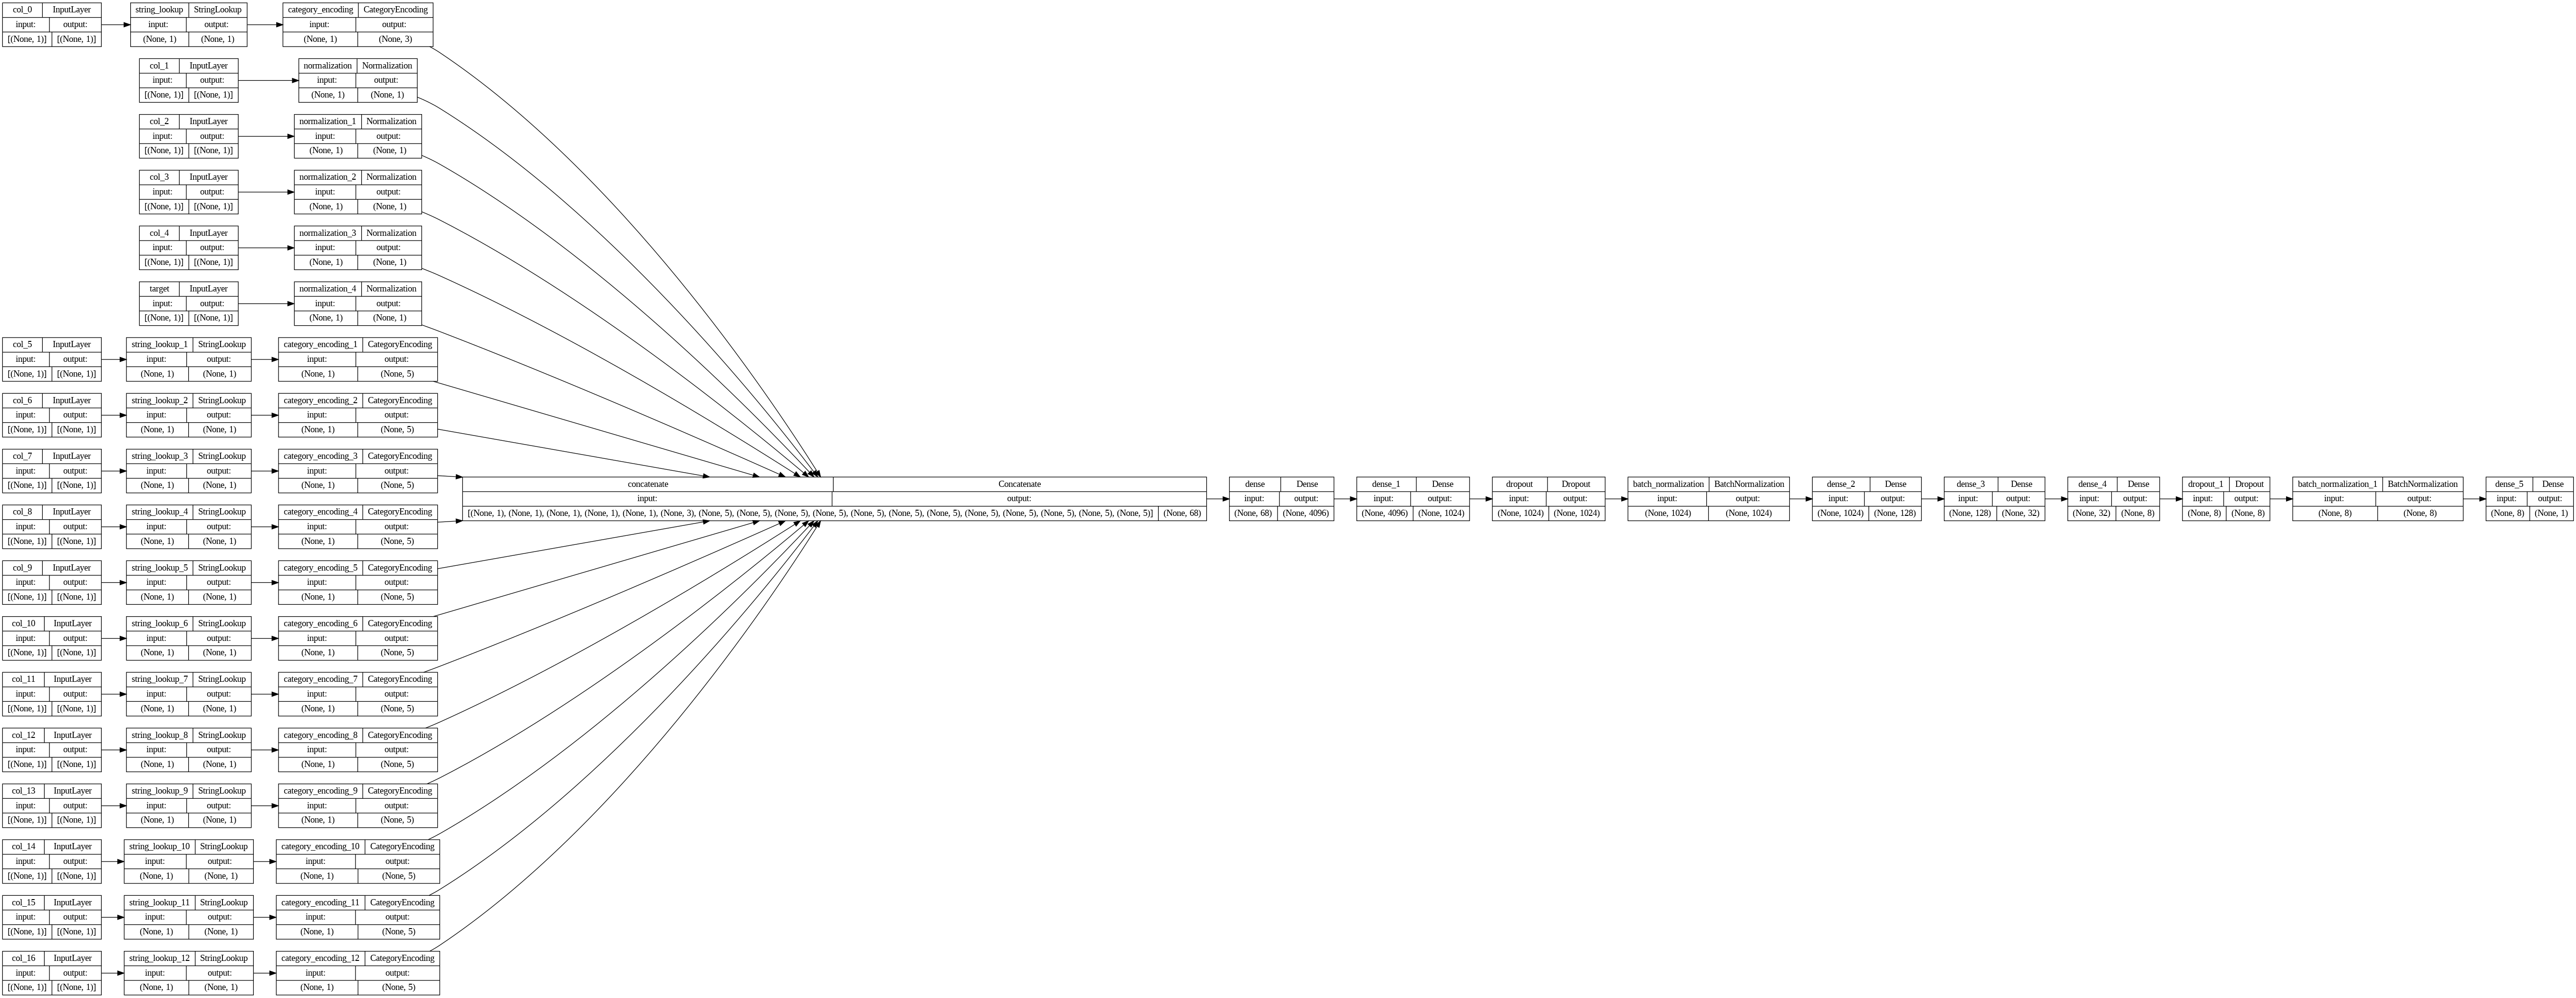

In [11]:
# Схема архитектуры. Пока не работает как нужно. Разбираюсь с этим
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 col_0 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 col_5 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 col_6 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 col_7 (InputLayer)             [(None, 1)]          0           []                               
                                                                                              

# Тест

1/1 [==============================] - 0s 15ms/step


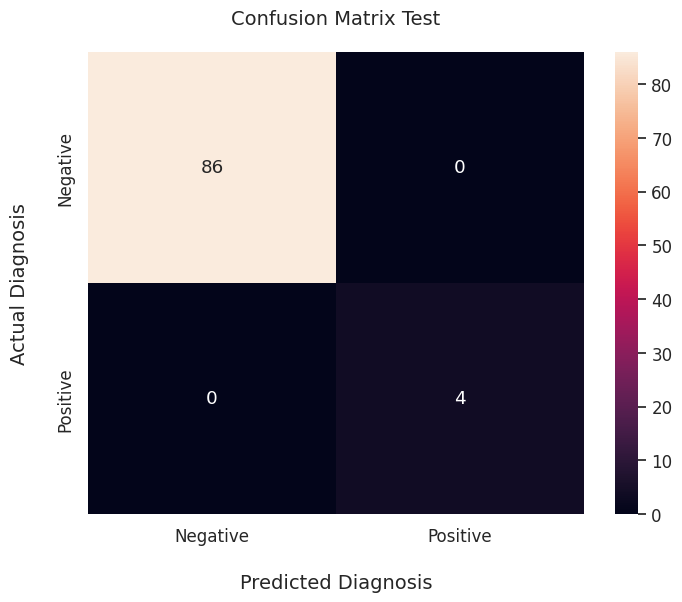

DummyClassifier: 0.96
recall_score: 1.00
precision_score: 1.00


In [13]:
# предобработка результата
predict_proba_one = np.array(pd.Series([x[0] for x in model.predict(test_ds)]), 'float32')
y_pred = np.array(pd.Series([1 if x[0]>0.5 else 0 for x in model.predict(test_ds)]), 'int64')
y_test.reset_index(drop=True)

# проверим модель на эффективность. Выводим матрицу ошибок
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Confusion Matrix Test", fontsize=14, pad=20)
plt.show()

clf = DummyClassifier(strategy='most_frequent', random_state=5)
clf.fit(X_train, y_train)
print("DummyClassifier: %.2f" % clf.score(X_test, y_test))
print("recall_score: %.2f" % recall_score(y_test, y_pred))
print("precision_score: %.2f" % precision_score(y_test, y_pred))
